# Computing and plotting 2d spatial point density in R

Author: Max Joseph

It is often useful to quickly compute a measure of point density and show it on a map. 
In this tutorial, we'll demonstrate this using storm event data from the [NOAA Storm Events Database](https://www.ncdc.noaa.gov/stormevents/) in 2015 across the U.S. 

## Objectives

- Compute 2d spatial density of points
- Plot the density surface with a basemap

## Dependencies

- ggmap
- wget
- gzip

First, we'll grab storm event data for 2015 from NOAA's ftp server:

In [1]:
library(ggmap)
options(jupyter.plot_mimetypes = 'image/png') # reduces file size

Loading required package: ggplot2


In [2]:
# pull data from ftp server
ftp_prefix <- 'ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/'
data_file <- 'StormEvents_locations-ftp_v1.0_d2015_c20160617.csv'
zipped_file <- paste0(data_file, ".gz")
fetch_cmd <- paste0("wget ", ftp_prefix, zipped_file)
system(fetch_cmd)

# unzip the csv file
system(paste("gzip -d", zipped_file)) 

Then, we will load and inspect the data.

In [3]:
d <- read.csv(data_file)
str(d)

'data.frame':	59269 obs. of  11 variables:
 $ YEARMONTH     : int  201512 201512 201512 201512 201512 201512 201512 201512 201512 201512 ...
 $ EPISODE_ID    : int  101377 101377 101377 101377 101382 100995 100995 100996 100997 100997 ...
 $ EVENT_ID      : int  606556 606556 606560 606560 606604 612634 612635 612627 604364 604364 ...
 $ LOCATION_INDEX: int  1 2 1 2 1 1 1 1 1 2 ...
 $ RANGE         : num  10.42 3.81 0 0 0.9 ...
 $ AZIMUTH       : Factor w/ 16 levels "E","ENE","ESE",..: 15 5 4 4 5 2 15 9 7 4 ...
 $ LOCATION      : Factor w/ 16797 levels "(01R)AFB GNRY RNG AL",..: 15517 11581 11261 14862 7220 13850 13972 4650 16457 16457 ...
 $ LATITUDE      : num  -14.3 -14.3 -14.2 -14.3 32.8 ...
 $ LONGITUDE     : num  -170.8 -170.6 -169.7 -169.5 -93.1 ...
 $ LAT2          : int  -1419464 -1415468 -1412000 -1418000 3247400 4031800 413600 3955200 3027366 3029274 ...
 $ LON2          : int  17050082 17033804 16942000 16930000 933600 12145600 12221600 12054000 9529964 9529502 ...


The data contain storms in Hawaii, Alaska, and Puerto Rico, but let's assume that we're interested only in the lower 48 states. 
We can filter the data based on the latitude and longitude values to remove points outside of our region of interest.

In [4]:
d <- subset(d, LATITUDE < 50 & LATITUDE > 22 & LONGITUDE > -125)

Let's visualize the location data, adding some alpha transparency and reducing the size of the points to avoid overplotting.

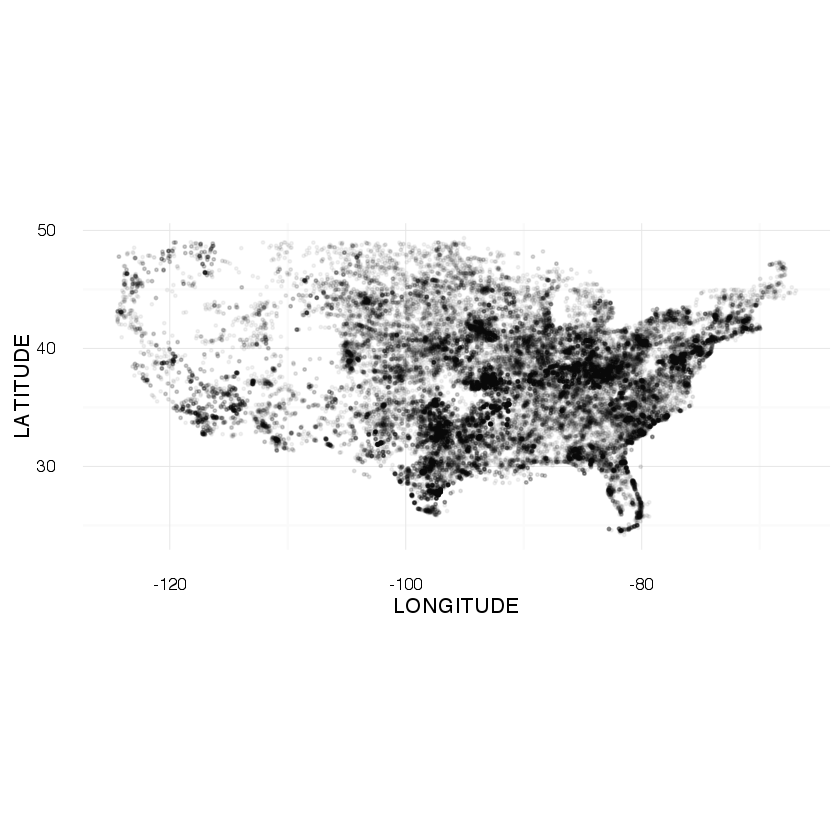

In [5]:
ggplot(d, aes(x = LONGITUDE, y = LATITUDE)) + 
  geom_point(alpha = .05, size = .3) + 
  theme_minimal() +
  coord_equal()

Now, let's compute a spatial density and visualize it. 
Note that there are many ways to compute densities, and if the mechanics of density estimation are important for your application, it is worth investigating packages that specialize in point pattern analysis (e.g., [spatstat](https://cran.r-project.org/web/packages/spatstat/index.html)). 
If on the other hand, you're lookng for a quick and dirty implementation for the purposes of exploratory data analysis, you can also use ggplot's [`stat_density2d`](http://docs.ggplot2.org/0.9.3.1/stat_density2d.html), which uses [`MASS::kde2d`](https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/kde2d.html) on the backend to estimate the density using a bivariate normal kernel.
Combined with the basemap functionality of `ggmap`, visualizing spatial density is fairly straightforward:

In [6]:
# acquire basemap within bounding box
bbox <- make_bbox(LONGITUDE, LATITUDE, data = d, .5)
map <- get_map(location = bbox, maptype = 'satellite', color = 'bw')

Warning message:
: bounding box given to google - spatial extent only approximate.converting bounding box to center/zoom specification. (experimental)
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=36.77,-95.7019&zoom=3&size=640x640&scale=2&maptype=satellite&language=en-EN&sensor=false


You can pass arguments for `kde2d` through the call to `stat_density2d`. 
In this case, we alter the argument `h`, which is a bandwidth parameter related to the spatial range or smoothness of the density estimate. 

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Warning message:
: Removed 1 rows containing missing values (geom_rect).

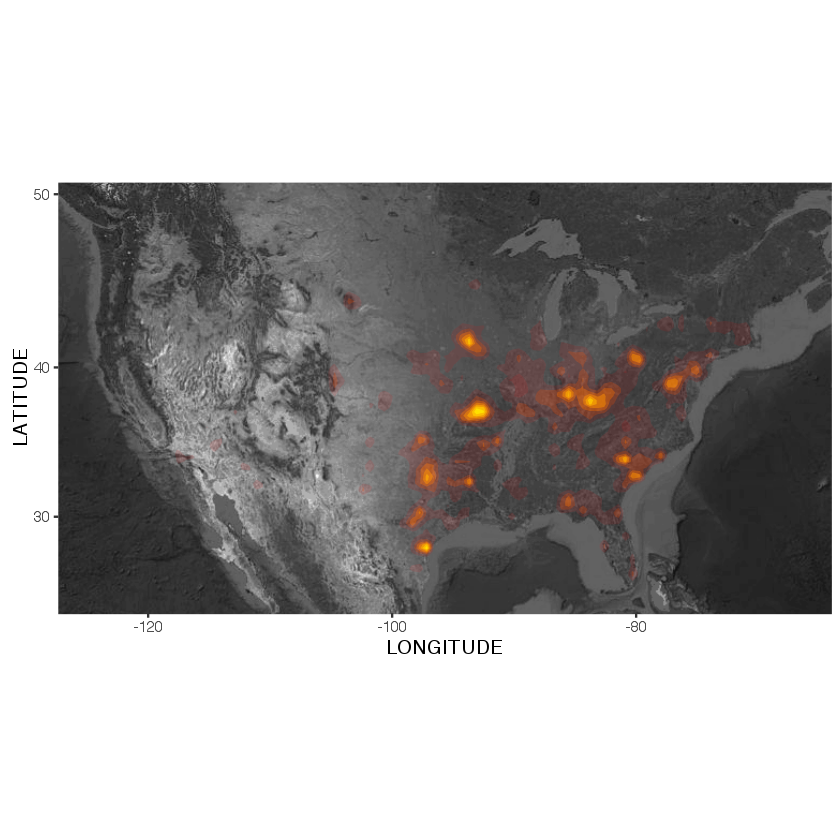

In [7]:
ggmap(map, 
      base_layer = ggplot(aes(x = LONGITUDE, y = LATITUDE), 
                          data = d)) + 
  stat_density2d(aes(fill = ..level.., alpha = ..level..), 
                 geom = "polygon", h = 1) + 
  scale_fill_gradient(low="red", high="yellow") + 
  theme(legend.position = 'none') + 
  ylim(range(d$LATITUDE)) + 
  xlim(range(d$LONGITUDE))

In [8]:
# clean up the directory
file.remove(data_file)

[1] TRUE